In [1]:
import os
import io
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from argparse import Namespace
from collections import defaultdict
from env.VRPInstance import VRPInstance
from plotly.subplots import make_subplots
from env.utils import load_scores, sort_instances
from tensorboard.backend.event_processing import event_accumulator

In [2]:
# Baseline
VNS_heuristic_scores = {
    "X-n101-k25.vrp":	28588,
    "X-n106-k14.vrp":	26740,
    "X-n110-k13.vrp":	15264,
    "X-n115-k10.vrp":	12823,
    "X-n120-k6.vrp":	13746,
    "X-n125-k30.vrp":	56555,
    "X-n129-k18.vrp":	29709,
    "X-n134-k13.vrp":	11206,
    "X-n139-k10.vrp":	13793,
    "X-n143-k7.vrp":	16432,
    "X-n148-k46.vrp":	43986,
    "X-n153-k22.vrp":	22292,
    "X-n157-k13.vrp":	16972,
    "X-n162-k11.vrp":	14263,
    "X-n167-k10.vrp":	21143,
    "X-n172-k51.vrp":	46543,
    "X-n176-k26.vrp":	48971,
    "X-n181-k23.vrp":	25828,
    "X-n186-k15.vrp":	24787,
    "X-n190-k8.vrp":	17432,
    "X-n195-k51.vrp":	45297,
    "X-n200-k36.vrp":	60127,
    "X-n204-k19.vrp":	19960,
    "X-n209-k16.vrp":	31658,
    "X-n214-k11.vrp":	11296,
    "X-n219-k73.vrp":	117935,
    "X-n223-k34.vrp":	41540,
    "X-n228-k23.vrp":	26199,
    "X-n233-k16.vrp":	19833,
    "X-n237-k14.vrp":	27647,
    "X-n242-k48.vrp":	84081,
    "X-n247-k50.vrp":	38533,
    "X-n251-k28.vrp":	39552,
    "X-n256-k16.vrp":	19283,
    "X-n261-k13.vrp":	27352,
    "X-n266-k58.vrp":	77507,
    "X-n270-k35.vrp":	36111,
    "X-n275-k28.vrp":	21815,
    "X-n280-k17.vrp":	34659,
    "X-n284-k15.vrp":	20878,
    "X-n289-k60.vrp":	97897,
    "X-n294-k50.vrp":	48203,
    "X-n298-k31.vrp":	35532,
    "X-n303-k21.vrp":	22543,
    "X-n308-k13.vrp":	26605,
    "X-n313-k71.vrp":	96628,
    "X-n317-k53.vrp":	79129,
    "X-n322-k28.vrp":	30991,
    "X-n327-k20.vrp":	28867,
    "X-n331-k15.vrp":	32125,
    "X-n336-k84.vrp":	142258,
    "X-n344-k43.vrp":	43368,
    "X-n351-k40.vrp":	26578,
    "X-n359-k29.vrp":	53538,
    "X-n367-k17.vrp":	23987,
    "X-n376-k94.vrp":	148355,
    "X-n384-k52.vrp":	68423,
    "X-n393-k38.vrp":	39856,
    "X-n401-k29.vrp":	67771,
    "X-n411-k19.vrp":	20624,
    "X-n420-k130.vrp":	110505,
    "X-n429-k61.vrp":	67499,
    "X-n439-k37.vrp":	37074,
    "X-n449-k29.vrp":	58101,
    "X-n459-k26.vrp":	25535,
    "X-n469-k138.vrp":	230351,
    "X-n480-k70.vrp":	91887,
    "X-n491-k59.vrp":	68555,
    "X-n502-k39.vrp":	69971,
    "X-n513-k21.vrp":	25414,
    "X-n524-k153.vrp":	157354,
    "X-n536-k96.vrp":	98060,
    "X-n548-k50.vrp":	88752,
    "X-n561-k42.vrp":	44378,
    "X-n573-k30.vrp":	52059,
    "X-n586-k159.vrp":	197669,
    "X-n599-k92.vrp":	112460,
    "X-n613-k62.vrp":	62205,
    "X-n627-k43.vrp":	64805,
    "X-n641-k35.vrp":	66801,
    "X-n655-k131.vrp":	107469,
    "X-n670-k130.vrp":	150623,
    "X-n685-k75.vrp":	71130,
    "X-n701-k44.vrp":	85231,
    "X-n716-k35.vrp":	45519,
    "X-n733-k159.vrp":	139838,
    "X-n749-k98.vrp":	80269,
    "X-n766-k71.vrp":	119155,
    "X-n783-k48.vrp":	76475,
    "X-n801-k40.vrp":	76461,
    "X-n819-k171.vrp":	164244,
    "X-n837-k142.vrp":	199937,
    "X-n856-k95.vrp":	90906,
    "X-n876-k59.vrp":	102839,
    "X-n895-k37.vrp":	57365,
    "X-n916-k207.vrp":	340623,
    "X-n936-k151.vrp":	138629,
    "X-n957-k87.vrp":	88487,
    "X-n979-k58.vrp":	122827,
    "X-n1001-k43.vrp":	76363,
}

In [3]:
def compute_gap(scores):
    gaps = []
    for name, score in scores.items():
        baseline_score = VNS_heuristic_scores[name]
        gap = (baseline_score - score) / baseline_score
        gaps.append(gap)
    average_gap = np.mean(gaps)
    return average_gap

In [4]:
def read_tensorboard_event(folder):
    for file in os.listdir(folder):
        if "events" in file:
            event = event_accumulator.EventAccumulator(os.path.join(folder, file))
            event.Reload()
            return event

In [5]:
def load_all_scores(log_folder, seeds):
    data = defaultdict(list)
    for seed in seeds:
        folder = f"{log_folder}/seed_{seed}"
        data["Folder"].append(folder)
        event = read_tensorboard_event(folder)
        steps = event.Scalars("steps")
        running_time = steps[-1].wall_time - steps[0].wall_time
        keys = sort_instances(VNS_heuristic_scores.keys())
        for key in keys:
            scores = [x.value for x in event.Scalars(f"scores/{key}")]
            data[key].append(scores)
        data["Running Time"].append(round(running_time, 2))
    df = pd.DataFrame(data).set_index(["Folder", "Running Time"])
    return df

In [6]:
def plotly_fig2array(fig):
    fig_bytes = fig.to_image(format="png")
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return np.asarray(img)

In [7]:
def instance_fig(df, key):
    best_folder, _ = df[key].idxmin()
    data = load_scores(best_folder)[key]
    solution = data.solution
    args = Namespace(round_int=False, algo=None)
    instance = VRPInstance.from_path(f"dataset/train/data_cvrp/{key}", args, f"sub_{key}")
    instance.solution = solution
    fig = instance.plot()
    return fig, data.score

In [8]:
print("HGS (lambda=0.1) scores:")
vrp_hgs_df = load_all_scores("logs/dataset_train_data_cvrp_HGS_0.1", range(1, 4))
vrp_hgs_best_score = vrp_hgs_df.applymap(lambda x: min(x))
vrp_hgs_best_score.round(2)

HGS (lambda=0.1) scores:


X-n101-k25.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             27591.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             27591.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             27591.0   

                                                          X-n106-k14.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             26375.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             26391.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             26388.0   

                                                          X-n110-k13.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             14971.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             14971.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             14971.0   

                                                          X-n115-k10.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             12747.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             12747.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             12747.0   

                                                          X-n120-k6.vrp  \
Folder                                      Running Time                  
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29            13332.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31            13332.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16            13332.0   

                                                          X-n125-k30.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             55542.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             55542.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             55542.0   

                                                          X-n129-k18.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             28940.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             28940.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             28944.0   

                                                          X-n134-k13.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             10916.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             10916.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             10916.0   

                                                          X-n139-k10.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             13590.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31             13590.0   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16             13590.0   

                                                          X-n143-k7.vrp  ...  \
Folder                                      Running Time                 ...   
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29            15700.0  ...   
logs/dataset_train_data_cvrp_HGS_0.1/seed_2 41852.31            15700.0  ...   
logs/dataset_train_data_cvrp_HGS_0.1/seed_3 41588.16            15700.0  ...   

                                                          X-n819-k171.vrp  \
Folder                                      Running Time                    
logs/dataset_train_data_cvrp_HGS_0.1/seed_1 41638.29             158890.0   
lo

In [9]:
print("HGS (lambda=0.1) scores:")
vrp_hgs_overall = vrp_hgs_best_score.apply(lambda x: [min(x), max(x), np.mean(x), np.std(x)])
vrp_hgs_overall.index = ["Min", "Max", "Mean", "Std."]
vrp_hgs_overall

HGS (lambda=0.1) scores:


X-n101-k25.vrp  X-n106-k14.vrp  X-n110-k13.vrp  X-n115-k10.vrp  \
Min          27591.0    26375.000000         14971.0         12747.0   
Max          27591.0    26391.000000         14971.0         12747.0   
Mean         27591.0    26384.666667         14971.0         12747.0   
Std.             0.0        6.944222             0.0             0.0   

      X-n120-k6.vrp  X-n125-k30.vrp  X-n129-k18.vrp  X-n134-k13.vrp  \
Min         13332.0         55542.0    28940.000000         10916.0   
Max         13332.0         55542.0    28944.000000         10916.0   
Mean        13332.0         55542.0    28941.333333         10916.0   
Std.            0.0             0.0        1.885618             0.0   

      X-n139-k10.vrp  X-n143-k7.vrp  ...  X-n819-k171.vrp  X-n837-k142.vrp  \
Min          13590.0        15700.0  ...    158729.000000    195419.000000   
Max          13590.0        15700.0  ...    158964.000000    195710.000000   
Mean         13590.0        15700.0  ...    158861.000000    195565.000000   
Std.             0.0            0.0  ...        98.105386       118.802357   

      X-n856-k95.vrp  X-n876-k59.vrp  X-n895-k37.vrp  X-n916-k207.vrp  \
Min     89208.000000    100433.00000    54190.000000    331691.000000   
Max     89347.000000    101195.00000    54319.000000    332213.000000   
Mean    89262.333333    100707.00000    54251.666667    331936.000000   
Std.       60.664835       345.93641       52.816243       214.303523   

      X-n936-k151.vrp  X-n957-k87.vrp  X-n979-k58.vrp  X-n1001-k43.vrp  
Min     133113.000000    85757.000000   119697.000000     73354.000000  
Max     133476.000000    85898.000000   120620.000000     73633.000000  
Mean    133289.000000    85840.000000   120190.000000     73470.666667  
Std.       148.398113       60.216277      379.437303       118.390127  

[4 rows x 100 columns]

In [10]:
print("HGS (lambda=0.0) scores")
vrp_hgs_no_imitation_df = load_all_scores("logs/dataset_train_data_cvrp_HGS_0.0", range(1, 4))
vrp_hgs_no_imitation_best_score = vrp_hgs_no_imitation_df.applymap(lambda x: min(x))
vrp_hgs_no_imitation_best_score.round(2)

HGS (lambda=0.0) scores


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'logs/dataset_train_data_cvrp_HGS_0.0/seed_1'

In [ ]:
print("HGS (lambda=0.0) scores")
vrp_hgs_no_imitation_overall = vrp_hgs_no_imitation_best_score.apply(lambda x: [min(x), max(x), np.mean(x), np.std(x)])
vrp_hgs_no_imitation_overall.index = ["Min", "Max", "Mean", "Std."]
vrp_hgs_no_imitation_overall

In [11]:
print("VNS (lambda=0.1) scores")
vrp_vns_df = load_all_scores("logs/dataset_train_data_cvrp_VNS_0.1", range(1, 4))
vrp_vns_best_score = vrp_vns_df.applymap(lambda x: min(x))
vrp_vns_best_score.round(2)

VNS (lambda=0.1) scores


X-n101-k25.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             28080.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             28053.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             28027.0   

                                                          X-n106-k14.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             26583.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             26665.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             26644.0   

                                                          X-n110-k13.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             15369.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             15121.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             15131.0   

                                                          X-n115-k10.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             12882.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             12833.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             12823.0   

                                                          X-n120-k6.vrp  \
Folder                                      Running Time                  
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59            13418.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69            13624.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10            13445.0   

                                                          X-n125-k30.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             56348.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             56433.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             56412.0   

                                                          X-n129-k18.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             29018.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             29424.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             29774.0   

                                                          X-n134-k13.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             11003.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             11072.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             11047.0   

                                                          X-n139-k10.vrp  \
Folder                                      Running Time                   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             13738.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69             13771.0   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10             13738.0   

                                                          X-n143-k7.vrp  ...  \
Folder                                      Running Time                 ...   
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59            15879.0  ...   
logs/dataset_train_data_cvrp_VNS_0.1/seed_2 48770.69            16193.0  ...   
logs/dataset_train_data_cvrp_VNS_0.1/seed_3 48930.10            15882.0  ...   

                                                          X-n819-k171.vrp  \
Folder                                      Running Time                    
logs/dataset_train_data_cvrp_VNS_0.1/seed_1 48855.59             161225.0   
lo

In [12]:
print("VNS (lambda=0.1) scores")
vrp_vns_overall = vrp_vns_best_score.apply(lambda x: [min(x), max(x), np.mean(x), np.std(x)])
vrp_vns_overall.index = ["Min", "Max", "Mean", "Std."]
vrp_vns_overall

VNS (lambda=0.1) scores


X-n101-k25.vrp  X-n106-k14.vrp  X-n110-k13.vrp  X-n115-k10.vrp  \
Min     28027.000000    26583.000000    15121.000000     12823.00000   
Max     28080.000000    26665.000000    15369.000000     12882.00000   
Mean    28053.333333    26630.666667    15207.000000     12846.00000   
Std.       21.638443       34.778665      114.624023        25.78113   

      X-n120-k6.vrp  X-n125-k30.vrp  X-n129-k18.vrp  X-n134-k13.vrp  \
Min    13418.000000    56348.000000    29018.000000    11003.000000   
Max    13624.000000    56433.000000    29774.000000    11072.000000   
Mean   13495.666667    56397.666667    29405.333333    11040.666667   
Std.      91.412375       36.150918      308.917824       28.522895   

      X-n139-k10.vrp  X-n143-k7.vrp  ...  X-n819-k171.vrp  X-n837-k142.vrp  \
Min     13738.000000   15879.000000  ...    161126.000000    196878.000000   
Max     13771.000000   16193.000000  ...    161388.000000    197402.000000   
Mean    13749.000000   15984.666667  ...    161246.333333    197224.000000   
Std.       15.556349     147.319004  ...       108.019546       244.693005   

      X-n856-k95.vrp  X-n876-k59.vrp  X-n895-k37.vrp  X-n916-k207.vrp  \
Min     89948.000000   101339.000000    56209.000000    333588.000000   
Max     90239.000000   101493.000000    56388.000000    334232.000000   
Mean    90116.666667   101427.666667    56293.000000    333922.333333   
Std.      123.235096       64.999145       73.489228       263.489827   

      X-n936-k151.vrp  X-n957-k87.vrp  X-n979-k58.vrp  X-n1001-k43.vrp  
Min     137563.000000      86765.0000   122935.000000     75011.000000  
Max     139495.000000      87094.0000   123706.000000     75732.000000  
Mean    138644.333333      86943.0000   123384.666667     75325.333333  
Std.       805.423836        135.6638      327.579337       301.501060  

[4 rows x 100 columns]

In [ ]:
print("VNS (lambda=0.0) scores")
vrp_vns_no_imitation_df = load_all_scores("logs/dataset_train_data_cvrp_VNS_0.0", range(1, 4))
vrp_vns_no_imitation_best_score = vrp_vns_no_imitation_df.applymap(lambda x: min(x))
vrp_vns_no_imitation_best_score.round(2)

In [ ]:
print("VNS (lambda=0.0) scores")
vrp_vns_no_imitation_overall = vrp_vns_no_imitation_best_score.apply(lambda x: [min(x), max(x), np.mean(x), np.std(x)])
vrp_vns_no_imitation_overall.index = ["Min", "Max", "Mean", "Std."]
vrp_vns_no_imitation_overall

In [ ]:
hgs_running_time = np.mean(vrp_hgs_df.index.get_level_values("Running Time"))/3600
hgs_no_imitation_running_time = np.mean(vrp_hgs_no_imitation_df.index.get_level_values("Running Time"))/3600
vns_running_time = np.mean(vrp_vns_df.index.get_level_values("Running Time"))/3600
vns_no_imitation_running_time = np.mean(vrp_vns_no_imitation_df.index.get_level_values("Running Time"))/3600
print(f"HGS (lambda=0.1) running time = {hgs_running_time:.2f}h")
print(f"HGS (lambda=0.0) running time = {hgs_no_imitation_running_time:.2f}h")
print(f"VNS (lambda=0.1) running time = {vns_running_time:.2f}h")
print(f"VNS (lambda=0.0) running time = {vns_no_imitation_running_time:.2f}h")

In [ ]:
def get_gap_df(df, name, running_time):
    results = defaultdict(list)
    n = max(df.applymap(lambda x: len(x)).max())
    for i in range(n):
        score_df = df.applymap(lambda x: min(x[:i+1])).min()
        gap = compute_gap(score_df)
        results[name].append(gap)
        results["Running Time"].append((i+1)*running_time/n)
    results = pd.DataFrame(results)
    return results

In [ ]:
hgs_gap = get_gap_df(vrp_hgs_df, "HGS gap", hgs_running_time)
hgs_no_imitation_gap = get_gap_df(vrp_hgs_no_imitation_df, "HGS gap", hgs_no_imitation_running_time)
vns_gap = get_gap_df(vrp_vns_df, "VNS gap", vns_running_time)
vns_no_imitation_gap = get_gap_df(vrp_vns_no_imitation_df, "VNS gap", vns_no_imitation_running_time)

In [ ]:
print(f"HGS (lambda=0.1) gap: {hgs_gap.max()['HGS gap']*100:.2f}%")
print(f"HGS (lambda=0.0) loss gap: {hgs_no_imitation_gap.max()['HGS gap']*100:.2f}%")
print(f"VNS (lambda=0.1) gap: {vns_gap.max()['VNS gap']*100:.2f}%")
print(f"VNS (lambda=0.0) loss gap: {vns_no_imitation_gap.max()['VNS gap']*100:.2f}%")

In [ ]:
fig = go.Figure()
fig.add_scatter(x=[0, vns_running_time], y=[-0.022, -0.022], name="GA (heuristic)", mode="lines", line=dict(dash='dash', width=1))
fig.add_scatter(x=[0, vns_running_time], y=[-0.011, -0.011], name="SA (heuristic)", mode="lines", line=dict(dash='dash', width=1))
fig.add_scatter(x=[0, vns_running_time], y=[0, 0], name="VNS (heuristic) - baseline", mode="lines", line=dict(color='black', width=1))
fig.add_scatter(x=[0, vns_running_time], y=[0.004, 0.004], name="BACO (heuristic) - SOTA", mode="lines", line=dict(dash='dash', width=1))
fig.add_scatter(x=vns_gap["Running Time"], y=vns_gap["VNS gap"], name="Imitation RL (expert=VNS, lambda=0.1)", line=dict(width=2))
fig.add_scatter(x=vns_no_imitation_gap["Running Time"], y=vns_no_imitation_gap["VNS gap"], name="Imitation RL (expert=VNS, lambda=0.0)", line=dict(width=2))
fig.add_scatter(x=hgs_gap["Running Time"], y=hgs_gap["HGS gap"], name="Imitation RL (expert=HGS, lambda=0.1)", line=dict(width=2))
fig.add_scatter(x=hgs_no_imitation_gap["Running Time"], y=hgs_no_imitation_gap["HGS gap"], name="Imitation RL (expert=HGS, lambda=0.0)", line=dict(width=2))
fig.update_layout(xaxis_title="Running Time", xaxis_dtick=0.5, yaxis_title="Gap", yaxis_tickformat=",.0%", width=800, height=400)
fig.show("svg")

HGS (lambda=0.1) graphs


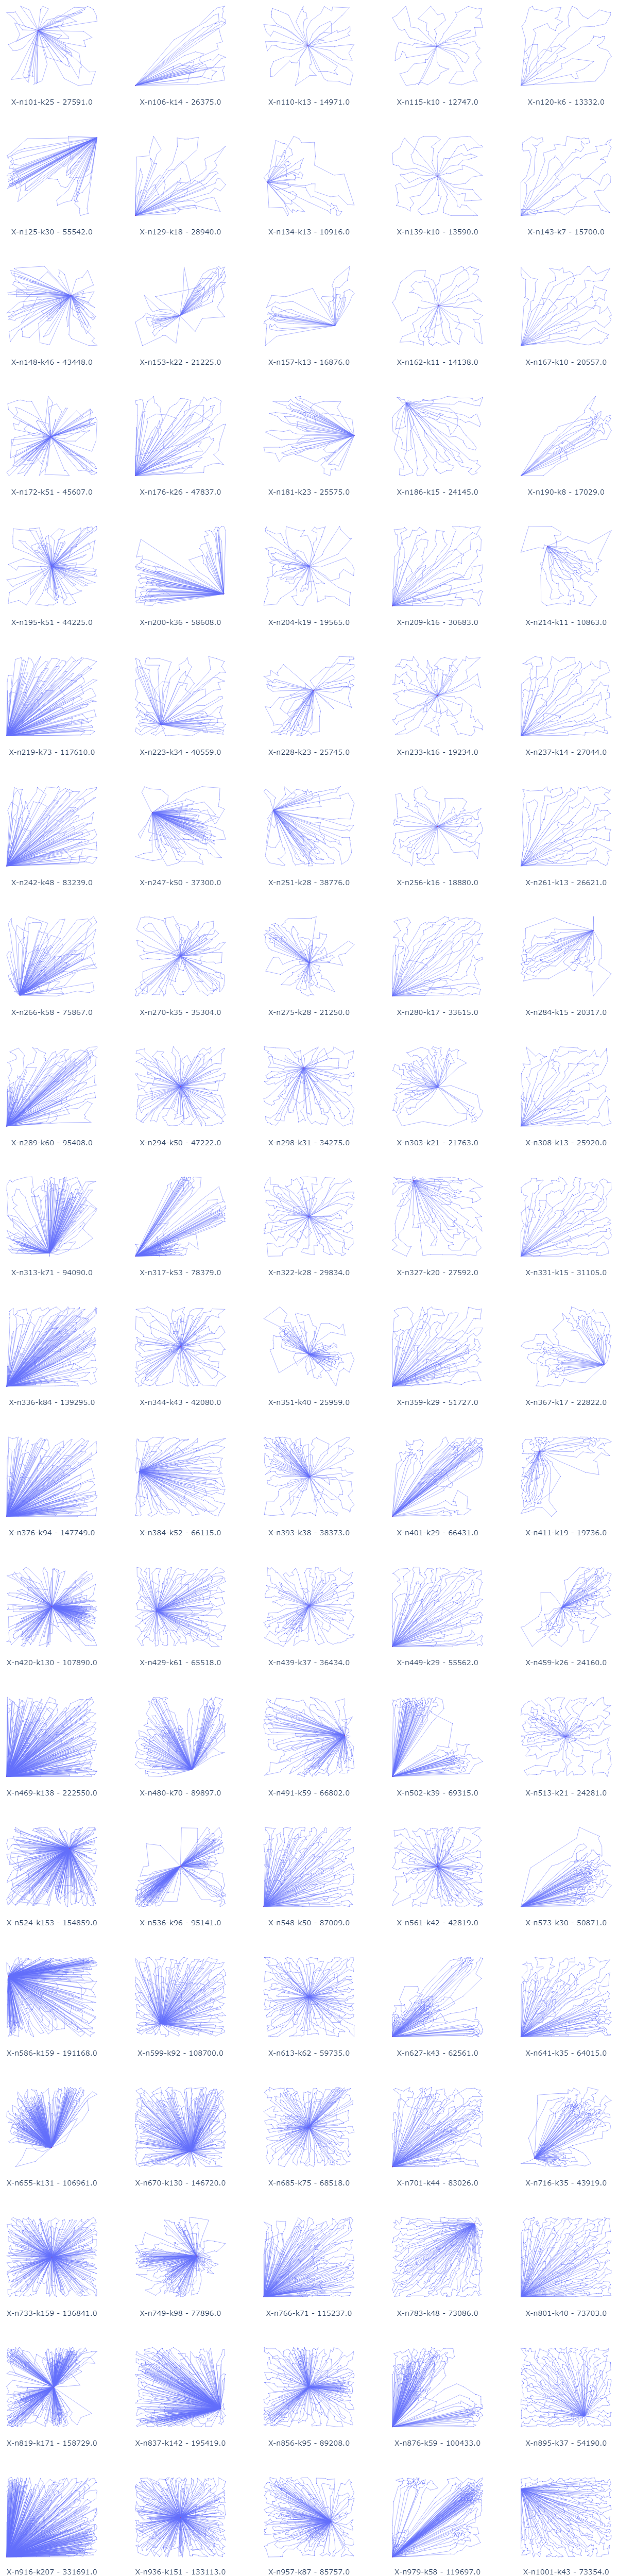

In [17]:
print("HGS (lambda=0.1) graphs")
fig = make_subplots(rows=4*5, cols=5)
os.makedirs("graphs/dataset_train_data_cvrp_HGS_0.1", exist_ok=True)
for i, key in enumerate(sort_instances(VNS_heuristic_scores.keys())):
    plotly_fig, score = instance_fig(vrp_hgs_best_score, key)
    plotly_fig.write_image(f"graphs/dataset_train_data_cvrp_HGS_0.1/{key}.pdf")
    title = key.split(".")[0] + f" - {score:.1f}"
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=title)
fig.update_layout(height=1000*5, width=1200)
fig.update_traces(line_width=0.5, marker_size=1)
fig.update_layout(template='plotly_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
fig.update_xaxes(showgrid=False, showticklabels=False, showline=False, zeroline=False)
fig.update_yaxes(visible=False)
fig.update_layout(showlegend=False)
fig.show("png")

In [ ]:
print("HGS (lambda=0.0) graphs")
fig = make_subplots(rows=4, cols=5, horizontal_spacing=0, vertical_spacing=0.05)
os.makedirs("graphs/dataset_train_data_cvrp_HGS_0.0", exist_ok=True)
for i, key in enumerate(sort_instances(VNS_heuristic_scores.keys())):
    if i >= 20: break
    plotly_fig, score = instance_fig(vrp_hgs_best_score, key)
    plotly_fig.write_image(f"graphs/dataset_train_data_cvrp_HGS_0.0/{key}.pdf")
    title = key.split(".")[0] + f" - {score:.1f}"
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=title)
fig.update_layout(height=1000, width=1200)
fig.update_traces(line_width=0.5, marker_size=1)
fig.update_layout(template='plotly_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
fig.update_xaxes(showgrid=False, showticklabels=False, showline=False, zeroline=False)
fig.update_yaxes(visible=False)
fig.update_layout(showlegend=False)
fig.show("svg")

VNS (lambda=0.1) graphs


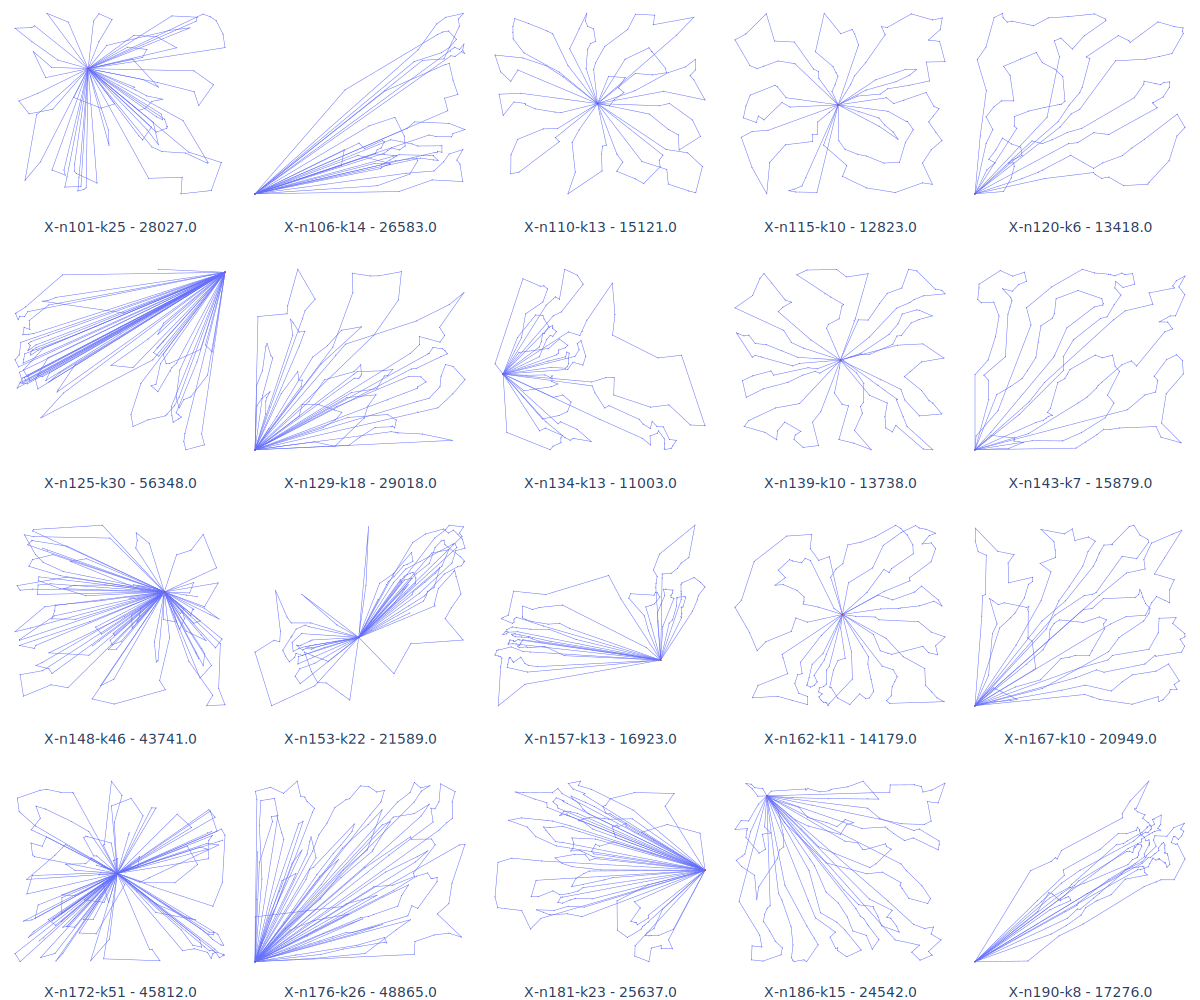

In [14]:
print("VNS (lambda=0.1) graphs")
fig = make_subplots(rows=4, cols=5, horizontal_spacing=0, vertical_spacing=0.05)
os.makedirs("graphs/dataset_train_data_cvrp_VNS_0.1", exist_ok=True)
for i, key in enumerate(sort_instances(VNS_heuristic_scores.keys())):
    if i >= 20: break
    plotly_fig, score = instance_fig(vrp_vns_best_score, key)
    plotly_fig.write_image(f"graphs/dataset_train_data_cvrp_VNS_0.1/{key}.pdf")
    title = key.split(".")[0] + f" - {score:.1f}"
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=title)
fig.update_layout(height=1000, width=1200)
fig.update_traces(line_width=0.5, marker_size=1)
fig.update_layout(template='plotly_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
fig.update_xaxes(showgrid=False, showticklabels=False, showline=False, zeroline=False)
fig.update_yaxes(visible=False)
fig.update_layout(showlegend=False)
fig.show("svg")

In [ ]:
print("VNS (lambda=0.0) graphs")
fig = make_subplots(rows=4, cols=5, horizontal_spacing=0, vertical_spacing=0.05)
os.makedirs("graphs/dataset_train_data_cvrp_VNS_0.0", exist_ok=True)
for i, key in enumerate(sort_instances(VNS_heuristic_scores.keys())):
    if i >= 20: break
    plotly_fig, score = instance_fig(vrp_vns_best_score, key)
    plotly_fig.write_image(f"graphs/dataset_train_data_cvrp_VNS_0.0/{key}.pdf")
    title = key.split(".")[0] + f" - {score:.1f}"
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=title)
fig.update_layout(height=1000, width=1200)
fig.update_traces(line_width=0.5, marker_size=1)
fig.update_layout(template='plotly_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
fig.update_xaxes(showgrid=False, showticklabels=False, showline=False, zeroline=False)
fig.update_yaxes(visible=False)
fig.update_layout(showlegend=False)
fig.show("svg")